## Astr 597A: astroML examples
### Zeljko Ivezic, UW, February 23, 2023

<a id='toc'></a>

## This notebook includes:

[Model selection using Bayesian Information Criterion (BIC)](#BICexample)

[Bayesian Blocks Algorithm](#BBexample)

## Model selection using Bayesian Information Criterion (BIC) <a id='BICexample'></a>
[Go to top](#toc)


### An Example Problem: 
We have N data points, $(x_i, y_i)$, i=1..N, and we want to fit a polynomial $y(x) = \sum_0^K a_j x^j$.
If $K$ is too small we will underfit the data, and if 
$K$ is too large we will overfit the data. How do we determine the polynomial order $K$? 

A side note: contrary to the popular opinion, it is not necessary that $K < N$! We can fit cases
with $K > N$ using the so-called regularization methods (which are equivalent to using strong Bayesian priors).

### Solution: 
When multiple models are considered, their BIC values, computed as
$${\rm BIC} = \chi^2 + k \ln N,$$ 
where $N$ is the number of data points and $k$ is the number of constrained
model parameters, are compared and the model with the smallest BIC value wins.   
 
Disclaimer: BIC is an approximation and might not be valid if the underlying 
assumptions (data ovecoming prior and Gaussian likelihood) are not met! In general, it is better to compute the model odds ratio when computationally feasible. 

A closely related metric is Akaike Information Criterion (AIC).
A statistically optimal polynomial order $K$ can also be estimated using cross-validation method. 

   
###  How do we interpret BIC? 

Given two models with the BIC difference:  
$$    \Delta BIC \equiv BIC_2 - BIC_1 = (\chi^2)_2 - (\chi^2)_1 + (k_2 - k_1)  \ln N,$$  
$\Delta BIC < -10$ is “decisive” evidence in favor of model 2 (model 2 is about one hundred times more probable than model 1), $-10 < \Delta BIC < -5$ is “strong” evidence in favor of model 2, and $-5 < \Delta BIC < -2$ is
“not worth more than a bare mention” (according to Jeffreys). 

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # set default plot styles
from scipy import stats
from scipy import optimize

# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, x, y, sigma_y, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, x, y, sigma_y, model=polynomial_fit):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, x, y, sigma_y, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

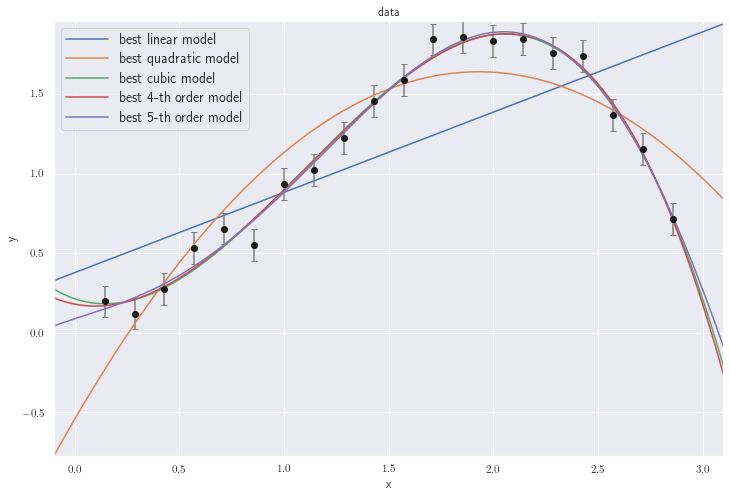

In [35]:
# numerical input parameters for this example
Ndata = 22  # the number of data points
NkTrue = 3  # for generating data
NkMax = 6   # fit polynomials up to this term

# generate (noisy) "data"
np.random.seed(0)
x = np.linspace(0, NkTrue, Ndata)[1:-1]
sigma_y = 0.1 + 0*x
y = np.random.normal(np.sin(x) * x, sigma_y) 

# get best-fit parameters for linear, quadratic, cubic... models
theta = {}
for k in range(1, NkMax):
    theta[k] = best_theta(k, x, y, sigma_y)

# generate best fit lines on a fine grid 
xfit = np.linspace(-0.1, 3.1, 1000)
yfit = {}
for k in range(1, NkMax):
    yfit[k] = polynomial_fit(theta[k], xfit)

# plot 
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta[1], xfit), label='best linear model')
ax.plot(xfit, polynomial_fit(theta[2], xfit), label='best quadratic model')
ax.plot(xfit, polynomial_fit(theta[3], xfit), label='best cubic model')
ax.plot(xfit, polynomial_fit(theta[4], xfit), label='best 4-th order model')
ax.plot(xfit, polynomial_fit(theta[5], xfit), label='best 5-th order model')

ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');

In [36]:
# compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
chi2 = {}
for k in range(1, NkMax):
    chi2[k] = np.sum(((y-polynomial_fit(theta[k], x))/sigma_y)**2) 
    
# the number of fitted parameters is (k+1)
BIC = {}
for k in range(1, NkMax):
    BIC[k] = chi2[k] + (k+1)*np.log(Ndata)

print ("         MODEL             CHI2          BIC")
print ('    best linear model:', chi2[1], BIC[1])
print (' best quadratic model:', chi2[2], BIC[2])
print ('     best cubic model:', chi2[3], BIC[3])
print ('best 4-th order model:', chi2[4], BIC[4])
print ('best 5-th order model:', chi2[5], BIC[5])
print ("")
print ("Therefore, the cubic model is the winner!")

         MODEL             CHI2          BIC
    best linear model: 349.65913513675673 355.84122004347336
 best quadratic model: 99.33135251840581 108.60447987848076
     best cubic model: 10.182096497819613 22.54626631125288
best 4-th order model: 10.090493156273212 25.545705423064792
best 5-th order model: 9.753601457780237 28.29985617793013

Therefore, the cubic model is the winner!


#### HOWEVER, not by much - we cannot really strongly reject the 4-th order model...

## Another Example: a dataset with 4 Gaussian components 


**Gaussian mixture model** is a relatively simple and straightfoward numerical method on obtaining data likelihood function, and expectation maximization algorithm for maximizing the likelihood.  
The likelihood of a datum $x_i$ for a Gaussian mixture model is given by  

$$p(x_i|\theta) = \sum_{j=1}^{M} \alpha_{j}\mathcal{N}(\mu_j, \sigma_j)$$  

where vector of parameters $\theta$ includes Gaussian arameters $\mu_j$ and $\sigma_j$, 
and $\alpha_j$, the normalization factor for each Gaussian. There are (3M-1) model
parameteres (not 3M because of the constraint $\sum_{j=1}^{M} \alpha_{j} = 1$).
Given $N$ data points $x_i$, i=1..N, how do we choose $M$? 

In [16]:
### Modeled after astroML book figure 4.2  
from sklearn.mixture import GaussianMixture as GMM

def doGMM(Ndata, noiseStd=0.00000001):
    #------------------------------------------------------------
    # Set up the dataset by drawing samples from Gaussians.
    #  We'll use scikit-learn's Gaussian Mixture Model to sample
    #  data from a mixture of 1-D Gaussians.  The usual way of using
    #  this involves fitting the mixture to data: we'll see that
    #  below.  Here we'll set the internal means, covariances,
    #  and weights by-hand and then generate a sample of requested 
    #  size Ndata. 
    N1 = int(0.2*Ndata)
    N2 = int(0.3*Ndata)
    N3 = int(0.2*Ndata)
    N4 = Ndata - (N1+N2+N3)
    random_state = np.random.RandomState(seed=1)
    X = np.concatenate([random_state.normal(-4, 1.1, N1),
                    random_state.normal(-1, 1.0, N2),
                    random_state.normal(0.9, 0.7, N3),
                    random_state.normal(3, 1.0, N4)]).reshape(-1, 1)
    X = np.random.normal(X, noiseStd)

    #------------------------------------------------------------
    # Learn (train) the best-fit GMM models
    # Here we'll use GMM in the standard way: the fit() method
    # uses an Expectation-Maximization approach to find the best
    # mixture of Gaussians for the data

    # fit models with 1-10 components
    N = np.arange(1, 11)
    models = [None for i in range(len(N))]
    for i in range(len(N)):
        models[i] = GMM(N[i]).fit(X)
    # compute the BIC for each model
    BIC = [m.bic(X) for m in models]

    #------------------------------------------------------------
    # Plot the results
    #  We'll use two panels:
    #   1) data + best-fit mixture
    #   2) BIC vs number of components 

    fig = plt.figure(figsize=(12, 7))
    fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


    # plot 1: data + best-fit mixture
    ax = fig.add_subplot(121)
    M_best = models[np.argmin(BIC)]

    x = np.linspace(-10, 10, 1000)
    logprob = M_best.score_samples(x.reshape(-1, 1))
    responsibilities = M_best.predict_proba(x.reshape(-1, 1))

    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    ax.hist(X, 'auto', density=True, histtype='stepfilled', alpha=0.4)
    ax.plot(x, pdf, '-k')
    ax.plot(x, pdf_individual, '--k')
    ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')

    # plot 2: BIC
    ax = fig.add_subplot(122)
    ax.plot(N, BIC, '--k')
    ax.set_xlabel('n. components')
    ax.set_ylabel('BIC')

    ibest = np.argmin(BIC)
    print(BIC[ibest-1]-BIC[ibest], BIC[ibest], BIC[ibest+1]-BIC[ibest])
    plt.show()

989.0337532594567 471777.8839657044 537.2973039324279


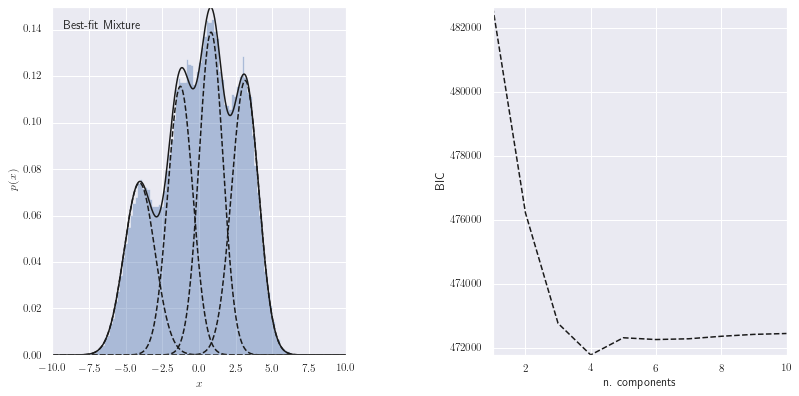

CPU times: user 4.9 s, sys: 3.16 s, total: 8.07 s
Wall time: 7.98 s


In [17]:
# let's see what we have, using a huge number of data points
%time doGMM(100000)    

Recall that $|\Delta BIC| = 5$ corresponds to “strong” evidence and $|\Delta BIC| = 10$ to “decisive” evidence.

We can conclude that the figure shows **hugely decisive** evidence in favor of the 4-component model. That is,
you should **not** argue that there are 3 peaks, or 5 peaks, in the left panel! 

What if we had a **much smaller** sample?

4.709128309128346 1448.7300687416134 15.446749241411226


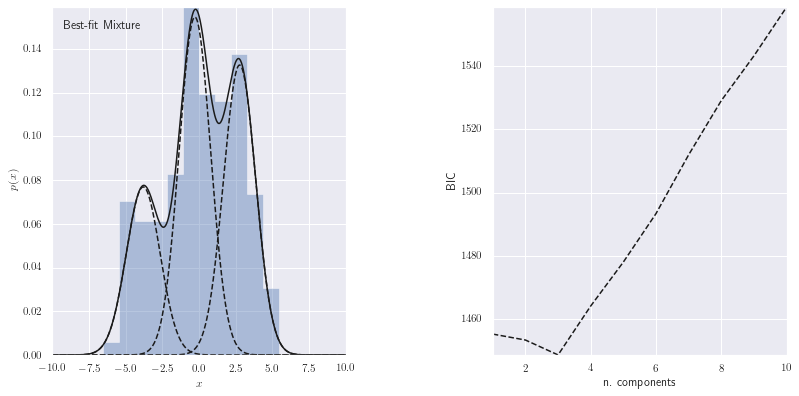

CPU times: user 630 ms, sys: 391 ms, total: 1.02 s
Wall time: 1.56 s


In [18]:
# what if we have a much smaller sample?
%time doGMM(300)  

##  How do we interpret BIC? 

The figure above (right panel) shows that the 3-component model has a BIC lower
by about 15 than the 4-component model. This is sufficient evidence to
claim that the 3-component model is a much better choice than the 4-component model. 

But because the sample size is small, we did not "discover" the 4th component! Altough we **did** draw that dataset from a model with 4 components, a sample of 300 values is insufficient to 
*discover* more than 3 components!

Note also that the evidence in favor of 3 components, compared to 2-component 
and single-component models is not overwhelming! Recall the phrase *“not worth more than a bare mention.”*

###  Therefore,  large sample size helps!  
### But one more thing: let's convolve our data with an arbitrary Gaussian to simulate measurement errors. 

97.4801228860124 25409.795376047605 29.156335621122707


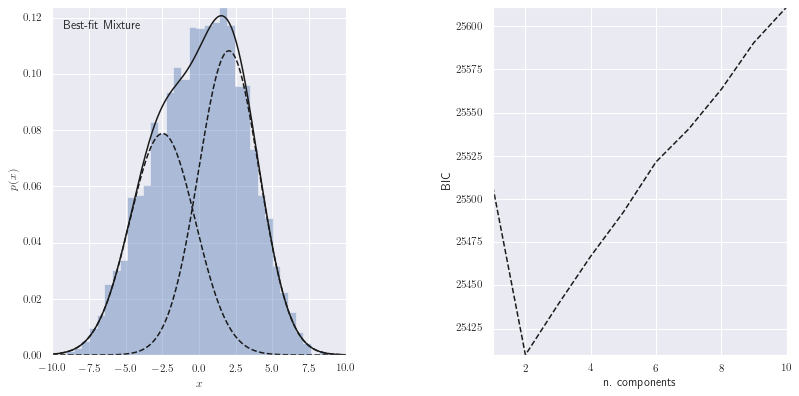

CPU times: user 1.09 s, sys: 708 ms, total: 1.8 s
Wall time: 2.5 s


In [19]:
%time doGMM(5000,1.5)

## **Conclusion**
### If you badly "blur" your sample, of course you will not see the fine structure (i.e. many components)! 

### Even with large samples, you still need to have precise and well calibrated  measurements!  LSST! 

## Bayesian Blocks Algorithm <a id='BBexample'></a>
[Go to top](#toc)

Classical histogram methods, such as the Freedman–Diaconis and Knuth's methods,
assume a constant bin width (the former is inferior to the latter because it produces the same answer for multimodal and unimodal distributions as long as their data set size and scale parameter are the same). This limitation can be lifted by maximizing a well-designed likelihood function over bins of varying width. This approach has been dubbed Bayesian blocks. The method was first developed in the field of time-domain analysis (by Jeff Scargle), but is readily applicable to histogram data as well. 

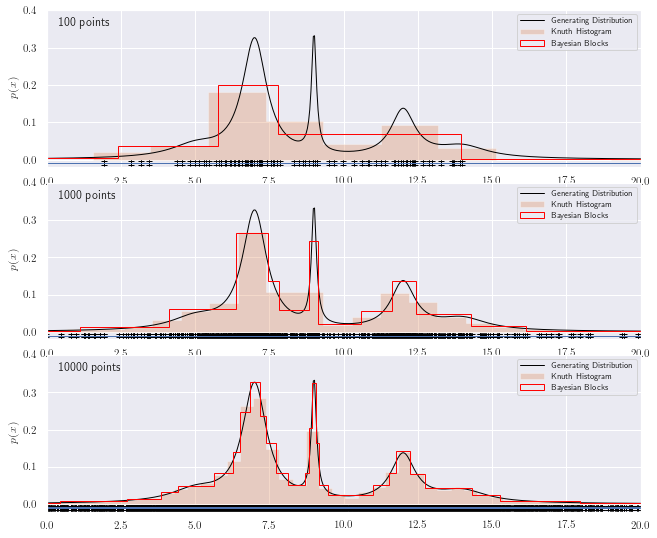

In [20]:
from scipy import stats
from astroML.plotting import hist
np.random.seed(42)

# Generate sample: a mix of several Cauchy distributions
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (100, 1000, 10000)
subplots = (311, 312, 313)

for N, subplot in zip(N_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)

    # plot the results
    ax.errorbar(xN, -0.01 + 0*xN, xerr=0.0, yerr=0.005, ecolor='black', lw=1)
    ax.plot(t, true_pdf(t), '-', color='black', lw=1,
            label="Generating Distribution")
    hist(xN, bins='knuth', ax=ax, density=True,
         histtype='stepfilled', alpha=0.3,
         label='Knuth Histogram')
    hist(xN, bins='blocks', ax=ax, density=True,
         histtype='step', color='red', alpha=0.99,
         label="Bayesian Blocks")
  
    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right', prop=dict(size=8))

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.02, 0.4001)

plt.show()

Note that for largest sample (N=10,000), both methods give similar results (e.g. three components are found in the data). 

However, for the middle dataset (N=1,000), the fixed bin width method (Knuth histogram) misses 
the middle peak.

This could be your missed Nobel prize!

[Go to top](#toc)